correlation - linearly related (if 0.8+ drop)
ViF - Variance Inflation Factor (1-6 okay, rest drop)
chi square - for nonlinear correlation
PCA - dimensionality reduction
Cross validation - model evaluate on different data parts

1. data cleaning
2. feature engineering
3. feature selection - selcet most important features
4. model training
5. model evaluation


HW:
XGBoost scoring (best guaranteed)

Logistic regression (default)

Deep Learning (new, hybrid - good for big dataset)

In [54]:
!pip install xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import xgboost as xgb
from sklearn.impute import SimpleImputer
import warnings
import joblib
warnings.filterwarnings('ignore')



In [56]:
# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [57]:
# Load the dataset
df = pd.read_csv('scoring_raw.csv')
df.head()

,age,months_on_file,annual_income,monthly_income,total_credit_limit,current_balance,num_open_accounts,num_closed_accounts,credit_utilization,avg_payment_delay_days,...,marital_status,residence_type,device_type,kyc_level,has_mobile_wallet,primary_bank,industry,card_type,default_flag,risk_score
0,38.483896,60.130698,1608.520603,134.043384,160.643860,25.287924,2.0,0,0.157416,0.417616,...,widowed,own,android,basic,yes,Ipoteka,services,credit,0,224
1,49.601710,101.801386,82249.760666,6854.146722,57715.606073,38215.483488,9.0,3,0.662134,7.926312,...,married,family,android,enhanced,no,UZCARD,services,credit,1,896
2,45.995639,91.053755,30567.582207,2547.298517,14314.990727,8174.391542,8.0,2,0.571037,5.740914,...,single,own,android,basic,yes,Ipoteka,construction,credit,0,807
3,52.479830,113.901075,243116.557392,20259.713116,340627.583117,274741.766249,10.0,5,0.806575,11.512414,...,widowed,dorm,ios,enhanced,yes,UZCARD,services,prepaid,1,931
4,41.956295,81.028236,14695.400359,1224.616697,2272.975873,805.934938,5.0,0,0.354573,2.308756,...,widowed,own,feature_phone,basic,no,Qishloq,retail,credit,1,670


In [58]:
# Display basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          6000 non-null   float64
 1   months_on_file               6000 non-null   float64
 2   annual_income                6000 non-null   float64
 3   monthly_income               6000 non-null   float64
 4   total_credit_limit           6000 non-null   float64
 5   current_balance              6000 non-null   float64
 6   num_open_accounts            6000 non-null   float64
 7   num_closed_accounts          6000 non-null   int64  
 8   credit_utilization           6000 non-null   float64
 9   avg_payment_delay_days       6000 non-null   float64
 10  num_delinquencies_12m        6000 non-null   int64  
 11  num_hard_inquiries_6m        6000 non-null   int64  
 12  num_soft_inquiries_6m        6000 non-null   int64  
 13  home_value_estimat

In [59]:
# Display basic statistics
print(df.describe())

               age  months_on_file  annual_income  monthly_income  \
count  6000.000000     6000.000000   6.000000e+03    6.000000e+03   
mean     44.074281       84.850497   1.154996e+06    9.624968e+04   
std       6.966084       23.697041   2.151022e+07    1.792518e+06   
min      18.000000        1.000000   1.879351e-01    1.566125e-02   
25%      39.370025       68.674813   1.955974e+03    1.629978e+02   
50%      43.985815       84.807197   1.374303e+04    1.145253e+03   
75%      48.721750      100.761264   9.759571e+04    8.132976e+03   
max      70.000000      180.000000   1.292165e+09    1.076804e+08   

       total_credit_limit  current_balance  num_open_accounts  \
count        6.000000e+03     6.000000e+03        6000.000000   
mean         6.495153e+06     6.058440e+06           5.986333   
std          1.861588e+08     1.752911e+08           3.411415   
min          9.690344e-03     4.990411e-04           1.000000   
25%          4.143049e+02     7.423287e+01           

In [60]:
# Check for missing values
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


In [61]:
# Handle missing values
for col in numerical_features:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)


In [62]:
# Check class distribution
print(df['default_flag'].value_counts(normalize=True))

default_flag
0    0.532
1    0.468
Name: proportion, dtype: float64


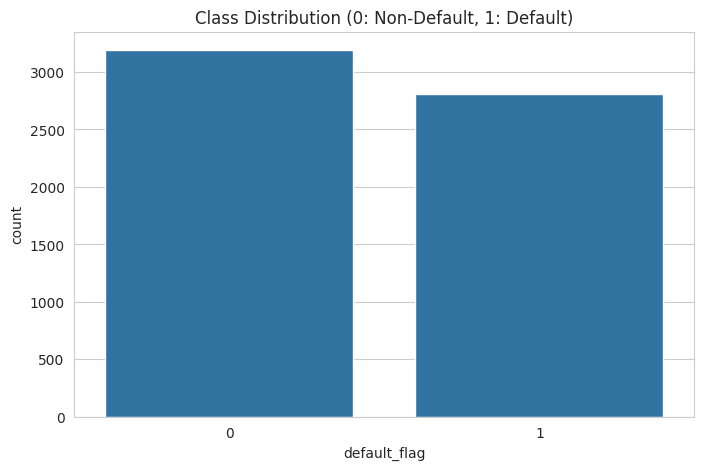

In [63]:
# Visualize the target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='default_flag', data=df)
plt.title('Class Distribution (0: Non-Default, 1: Default)')
plt.savefig('class_distribution.png')


In [64]:
# Drop the risk_score column if it exists
if 'risk_score' in df.columns:
    df = df.drop(columns=['risk_score'])
    print("Dropped 'risk_score' column")
    
    # Update numerical_features list if it exists
    if 'risk_score' in numerical_features:
        numerical_features.remove('risk_score')

Dropped 'risk_score' column


In [65]:
# Select numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from numerical features
if 'default_flag' in numerical_features:
    numerical_features.remove('default_flag')

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")   


Numerical features: 38
Categorical features: 10


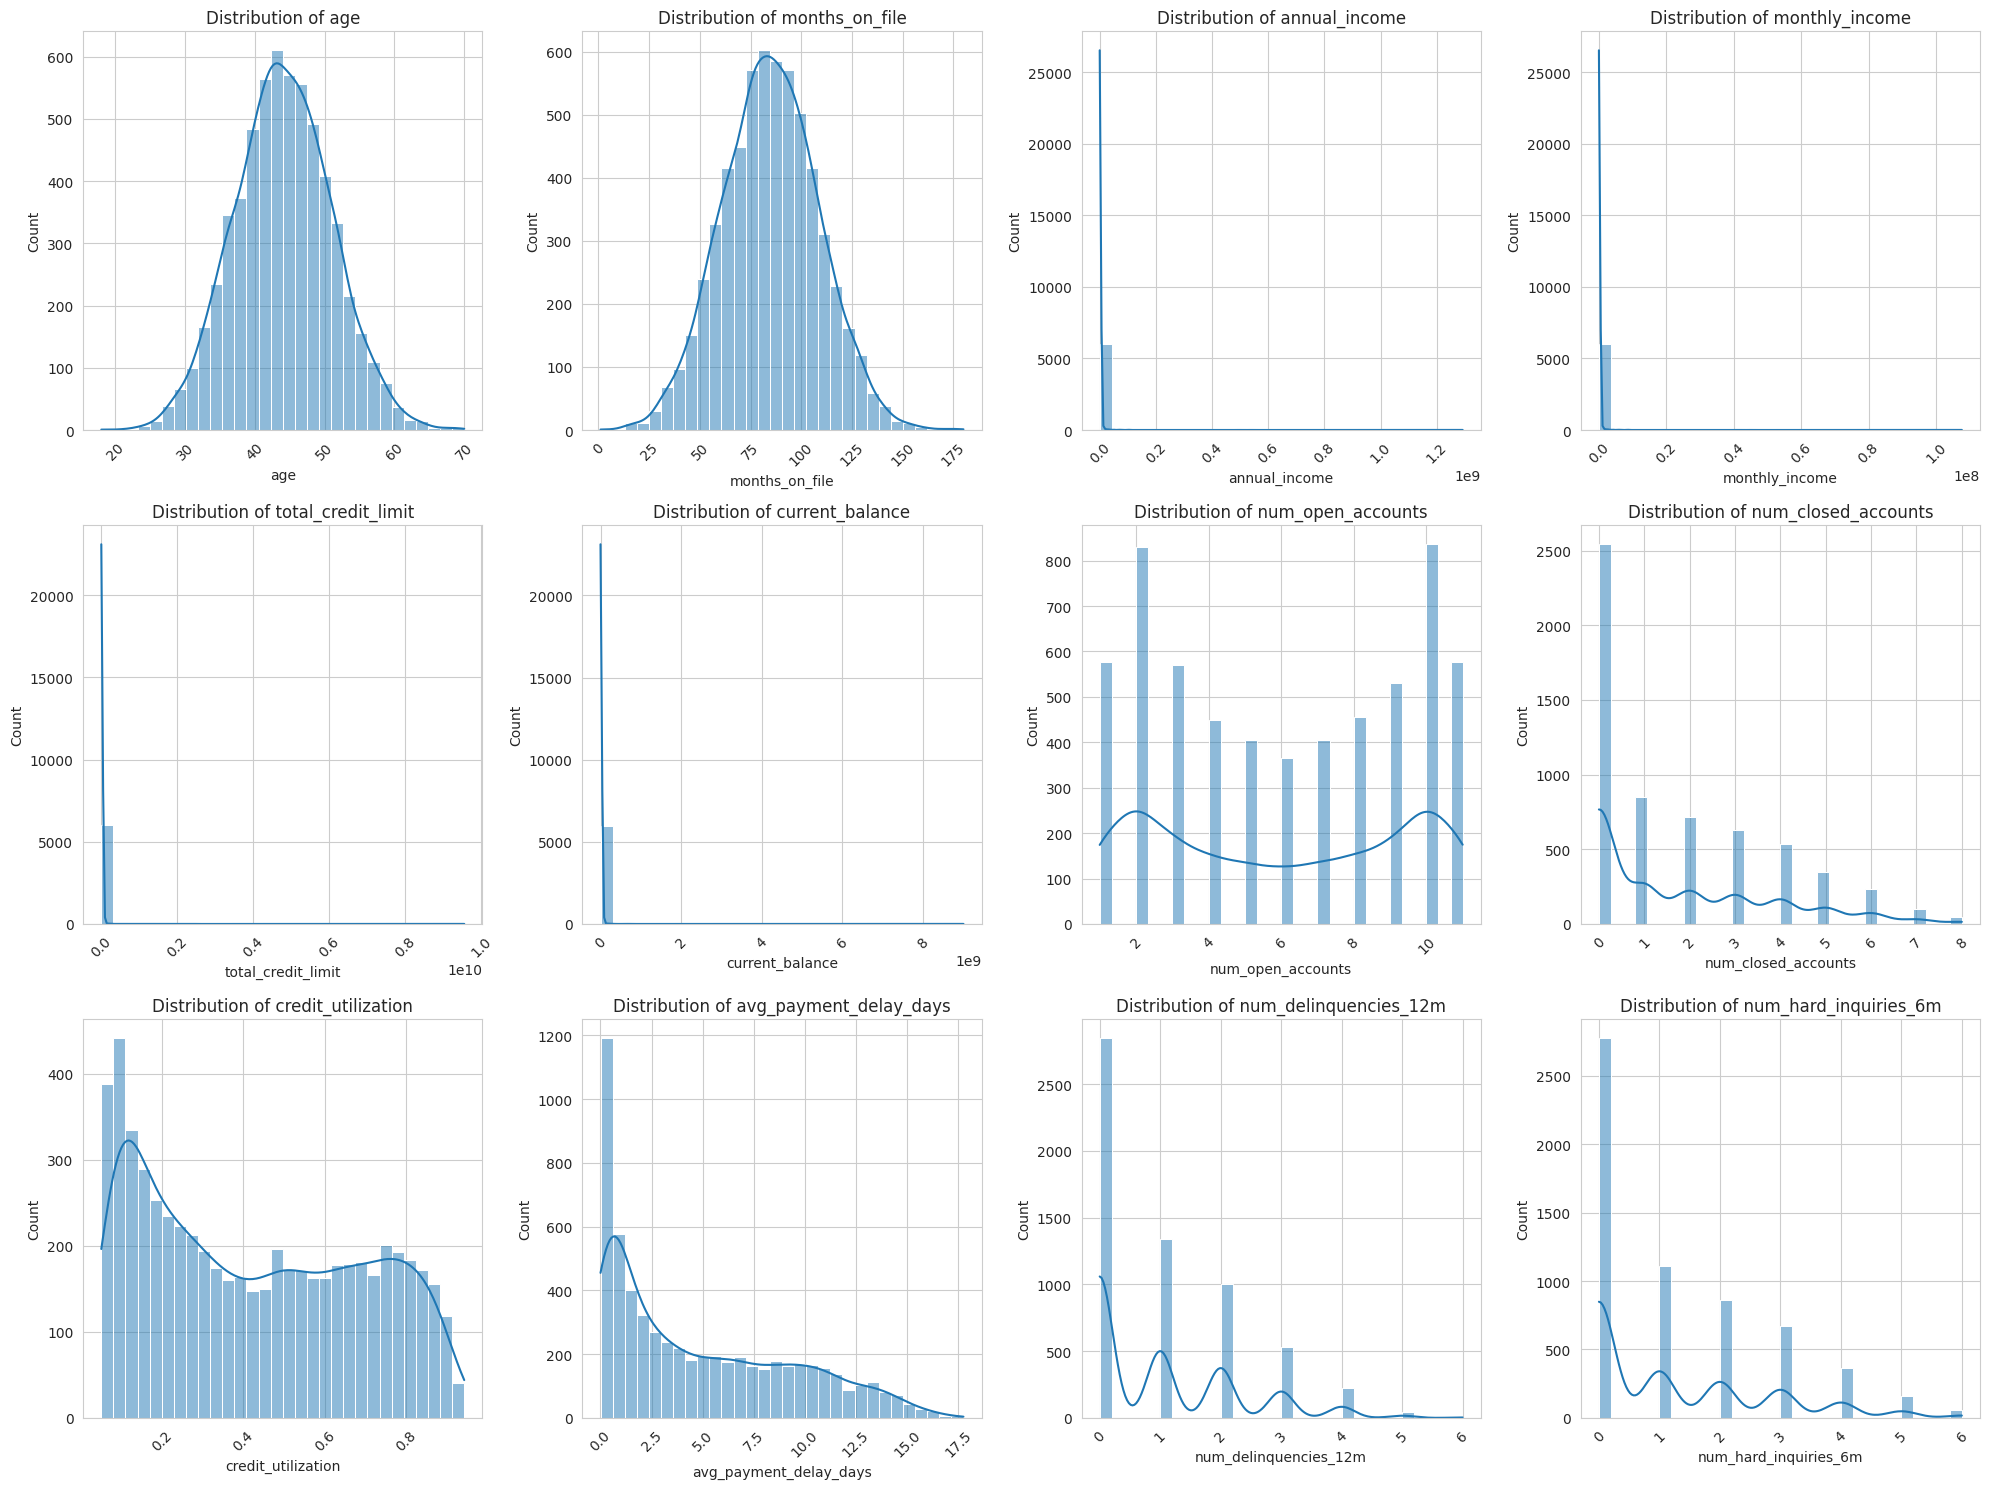

In [66]:
# Plot distributions of numerical features
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features[:12], 1):  # Plot first 12 numerical features
    plt.subplot(3, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('numerical_distributions.png')

In [67]:
# Create a figure with subplots for the financial features
plt.figure(figsize=(20, 15))

# Log transformation for better visualization of financial data
financial_features = ['annual_income', 'monthly_income', 'total_credit_limit', 'current_balance']

for i, col in enumerate(financial_features, 1):
    plt.subplot(2, 2, i)
    # Apply log transformation to handle large value ranges
    if (df[col] > 0).all():  # Ensure all values are positive for log
        sns.histplot(np.log1p(df[col]), kde=True, bins=30)
        plt.title(f'Distribution of log({col})')
    else:
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('financial_features_distributions.png')
plt.close()

# Box plots to show the distribution and outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(financial_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.savefig('financial_features_boxplots.png')
plt.close()

Plotting correlation matrix...


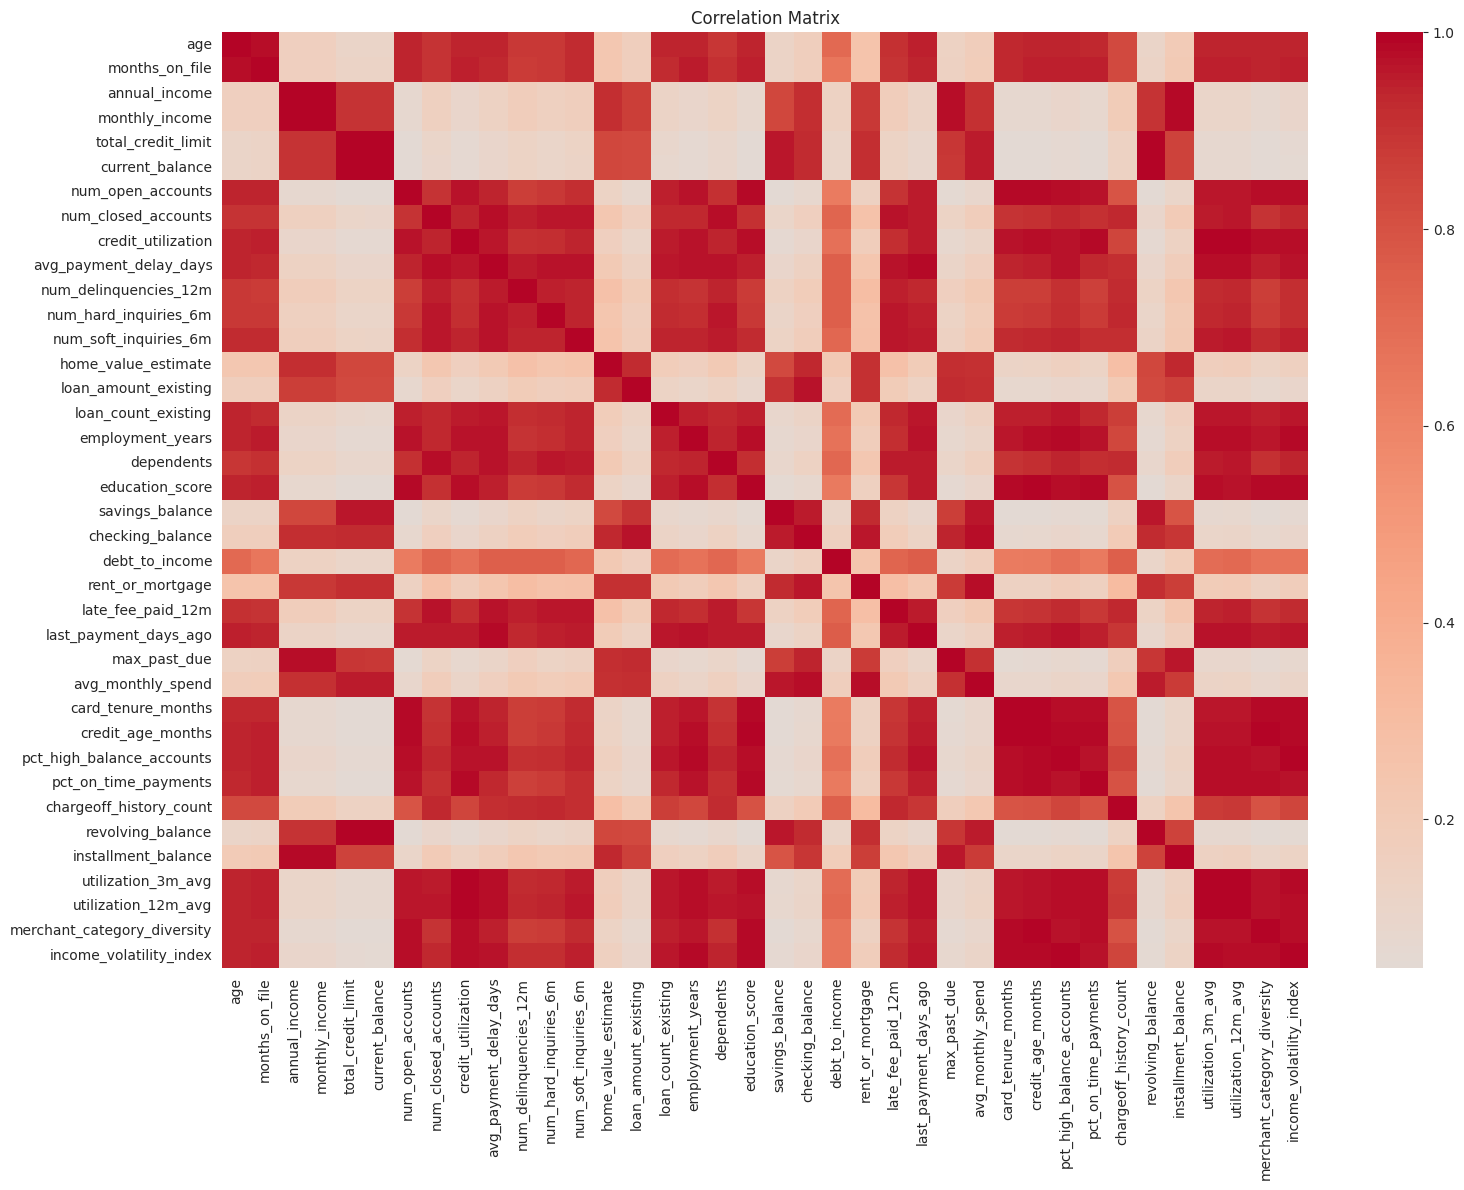

In [68]:
# Plot correlation matrix
print("Plotting correlation matrix...")
plt.figure(figsize=(16, 12))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

In [69]:
# Create a copy of the original dataframe
df_processed = df.copy()

# 1. First, apply label encoding to all categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_processed[f"{col}_label"] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 2. Then apply one-hot encoding and append to the same dataframe
df_processed = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

# 3. Remove the original categorical columns to avoid duplication
# (since we have both label and one-hot encoded versions now)
for col in categorical_features:
    if col in df_processed.columns:
        df_processed.drop(columns=[col], inplace=True)

# Save the label encoders for later use
joblib.dump(label_encoders, 'label_encoders.pkl')

# Now you can use df_processed for your models
# The features will include both _label and _onehot versions of categorical variables
X = df_processed.drop('default_flag', axis=1)
y = df_processed['default_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# For models that need scaling (like logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
# XGBoost Model Training
print("\n=== XGBoost Model Training ===")

# Define the model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_model


=== XGBoost Model Training ===


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [71]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_grid

{'max_depth': [3, 5, 7],
 'learning_rate': [0.01, 0.1, 0.3],
 'n_estimators': [100, 200],
 'subsample': [0.8, 1.0],
 'colsample_bytree': [0.8, 1.0]}

In [72]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [73]:
print("Performing grid search...")
grid_search.fit(X_train_scaled, y_train)

Performing grid search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [74]:
# Get the best model
best_xgb = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV AUC: 0.8451


In [75]:
# Model Evaluation
print("\n=== Model Evaluation ===")

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Print classification reports
    print("\nTraining Classification Report:")
    print(classification_report(y_train, y_train_pred))
    
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Calculate and print ROC AUC
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    print(f"\nTrain ROC AUC: {train_auc:.4f}")
    print(f"Test ROC AUC: {test_auc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
  
    
    # Plot feature importance
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Important Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png')




=== Model Evaluation ===



Training Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2554
           1       0.79      0.77      0.78      2246

    accuracy                           0.80      4800
   macro avg       0.80      0.80      0.80      4800
weighted avg       0.80      0.80      0.80      4800


Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       638
           1       0.76      0.69      0.72       562

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200


Train ROC AUC: 0.8852
Test ROC AUC: 0.8413


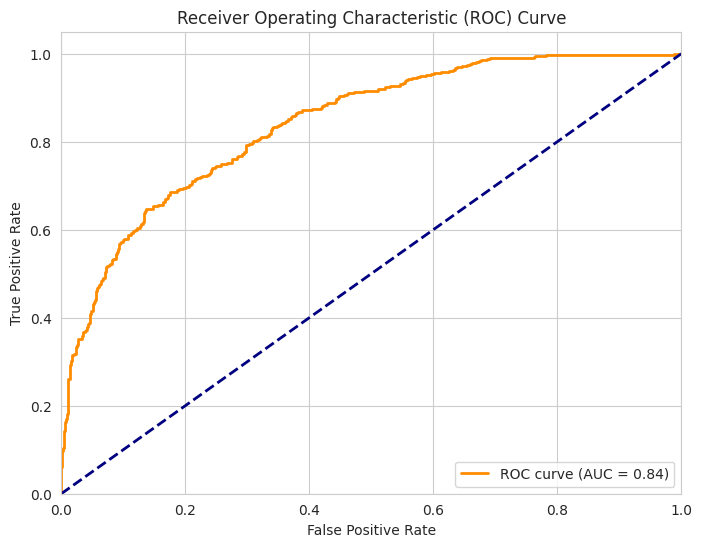

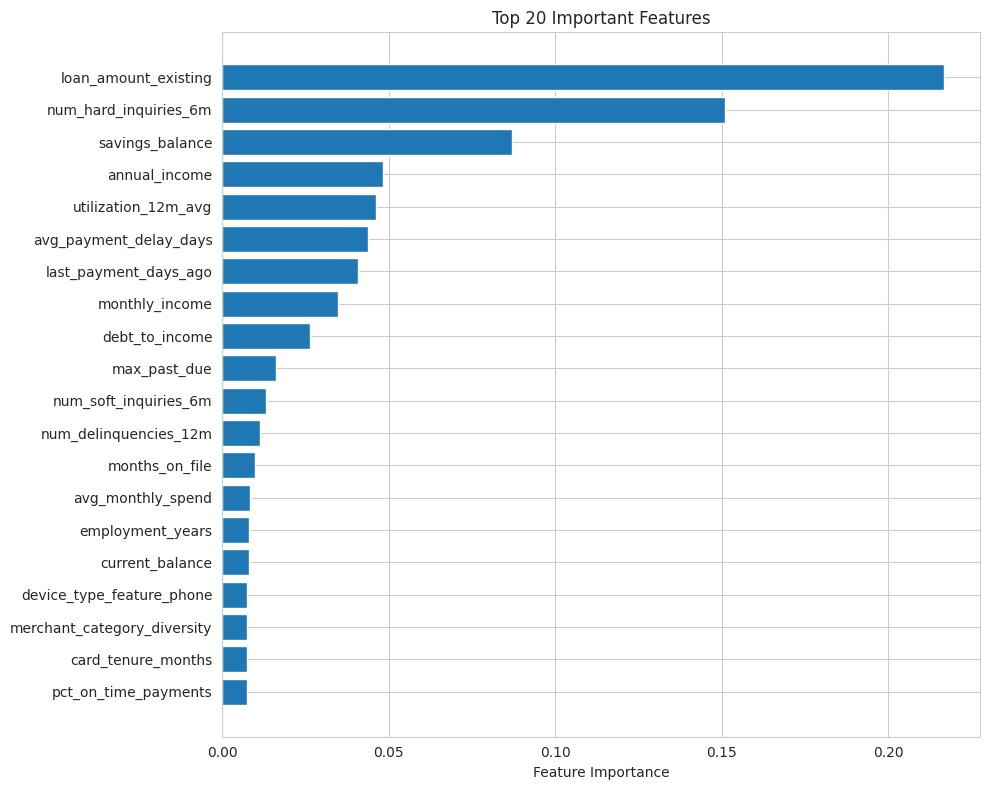

In [76]:
# Evaluate the best model
evaluate_model(best_xgb, X_train_scaled, X_test_scaled, y_train, y_test)


In [77]:
# Save the model
import joblib
joblib.dump(best_xgb, 'xgboost_credit_scoring_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("\n=== Model Training Complete ===")


=== Model Training Complete ===


In [78]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale the features (important for logistic regression)
scaler_lr = StandardScaler()
X_train_lr = scaler_lr.fit_transform(X_train)
X_test_lr = scaler_lr.transform(X_test)

In [79]:
# Define the logistic regression model
log_reg = LogisticRegression(
    penalty='l2',  # L2 regularization
    C=1.0,         # Inverse of regularization strength
    solver='liblinear',  # Good for small to medium datasets
    max_iter=1000,  # Maximum number of iterations
    random_state=42,
    n_jobs=-1
)

# Hyperparameter tuning for logistic regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'solver': ['liblinear', 'saga']  # Algorithms that support L1 regularization
}

In [ ]:
# Perform grid search with cross-validation
grid_search_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)


In [81]:
print("Training Logistic Regression model...")
grid_search_lr.fit(X_train_lr, y_train)

Training Logistic Regression model...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.001, 0.01, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [82]:
# Get the best model
best_lr = grid_search_lr.best_estimator_
print(f"\nBest parameters: {grid_search_lr.best_params_}")
print(f"Best CV AUC: {grid_search_lr.best_score_:.4f}")


Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV AUC: 0.8467


In [84]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_type='xgboost'):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Print classification reports
    print("\nTraining Classification Report:")
    print(classification_report(y_train, y_train_pred))
    
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Calculate and print ROC AUC
    train_auc = roc_auc_score(y_train, y_train_prob)
    test_auc = roc_auc_score(y_test, y_test_prob)
    print(f"\nTrain ROC AUC: {train_auc:.4f}")
    print(f"Test ROC AUC: {test_auc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_type.upper()}')
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_{model_type}.png')
    plt.close()
    
    # Plot feature importance/coefficients
    plt.figure(figsize=(10, 8))
    
    if hasattr(model, 'feature_importances_'):  # For XGBoost
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.title('Top 20 Important Features (XGBoost)')
    elif hasattr(model, 'coef_'):  # For Logistic Regression
        # Get the absolute coefficients for feature importance
        coef = np.abs(model.coef_[0])
        # Get top 20 features
        top_n = min(20, len(coef))
        sorted_idx = np.argsort(coef)[-top_n:]
        plt.barh(range(len(sorted_idx)), coef[sorted_idx], align='center')
        plt.title('Top 20 Most Important Features (Logistic Regression)')
    
    plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{model_type}.png')
    plt.close()

# For XGBoost
print("\n=== XGBoost Evaluation ===")
evaluate_model(best_xgb, X_train_scaled, X_test_scaled, y_train, y_test, model_type='xgboost')

# For Logistic Regression
print("\n=== Logistic Regression Evaluation ===")
evaluate_model(best_lr, X_train_lr, X_test_lr, y_train, y_test, model_type='logistic_regression')


=== XGBoost Evaluation ===

Training Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2554
           1       0.79      0.77      0.78      2246

    accuracy                           0.80      4800
   macro avg       0.80      0.80      0.80      4800
weighted avg       0.80      0.80      0.80      4800


Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       638
           1       0.76      0.69      0.72       562

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200


Train ROC AUC: 0.8852
Test ROC AUC: 0.8413

=== Logistic Regression Evaluation ===

Training Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      2554
           1       0.77      0

In [86]:
# feature engineering with chatgpt, new features for scoring